CHANGES MADE BASED ON FEEDBACK:

    - Changed indexes to column numbers from numbers, to the actual column names when creating distance and speed
    
    - Removed outlier data from speed, cut it off at 55km/h.
   
    - Removed heart Rate over 180, since it seemed to be an odd jump as you started riding and then went around that 150 mark from there. also over 200 isn't very normal consideing MHR is 220 - age.
    
    - Now have different outputs for the speed vs power and speed vs heart rate

Student name = Conor Apcar
StudentID = 44624336

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pylab as plt
%matplotlib inline 
tree = ET.parse('race1.gpx')
root = tree.getroot()
data = []

ns = {'gpx':'http://www.topografix.com/GPX/1/1','gpxtpx': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'} # Namespace dictiionary
trk = root.find('gpx:trk', ns) # Start looking through the xml file and finding elements
trkseg = trk.find('gpx:trkseg', ns)
for trkpt in trkseg: #iterate through trkseg finding elements
    lon = trkpt.attrib['lon']
    lat = trkpt.attrib['lat']
    ele = trkpt.find('gpx:ele', ns).text
    time = trkpt.find('gpx:time', ns).text
    ext = trkpt.find('gpx:extensions', ns)
    power = ext.find('gpx:power', ns).text
    tpext = ext.find('gpxtpx:TrackPointExtension', ns)
    temp = tpext.find('gpxtpx:atemp', ns).text
    hr = tpext.find('gpxtpx:hr', ns).text
    cad = tpext.find('gpxtpx:cad', ns).text
    row = lon, lat, ele, time, power, temp, hr, cad 
    data.append(row) # Create row for each set of data
names = 'Longitude','Latitude','Elevation','Time','Power','Temperature','HeartRate','Cadence' # Column names
RaceData = pd.DataFrame(data, columns = names) # Create Dataframe
RaceData.head()

,Longitude,Latitude,Elevation,Time,Power,Temperature,HeartRate,Cadence
0,150.8710320,-33.8161780,73.0,2017-07-08T22:05:45Z,0,7,115,27
1,150.8710350,-33.8161500,73.0,2017-07-08T22:05:46Z,0,7,115,27
2,150.8710440,-33.8161170,73.0,2017-07-08T22:05:47Z,0,7,115,27
3,150.8710540,-33.8160820,73.0,2017-07-08T22:05:48Z,0,7,115,27
4,150.8710690,-33.8160430,73.0,2017-07-08T22:05:49Z,197,7,115,27


Used the Haversine function in order to find the distance between two points. Decided that changing the distance into metres would be easier to read in the table before then changing into km/h for the speed.

used .iloc to locate each position in the table and keep the second point one row ahead as it is an integer based index. 

Was then able to calculate the average speed from this.

In [2]:
from math import radians, cos, sin, asin, sqrt
def haversine(long1, lat1, long2, lat2):
    long1, lat1, long2, lat2 = map(radians, [long1, lat1, long2, lat2])
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 #km
    return c * r * 1000 # Makes the distance into metres, making it easier to read

current = 0
next = 1
dist = [0] #Create dictionary for distance
for data in RaceData.iterrows(): # Iterate through rows
    if (next == 6377): 
        break # Break if no more rows
    else:
        long1 = RaceData.iloc[current]['Longitude'] #Indexes the specific position
        lat1 = RaceData.iloc[current]['Latitude']
        long2 = RaceData.iloc[next]['Longitude']
        lat2 = RaceData.iloc[next]['Latitude'] 
        row = haversine(float(long1), float(lat1), float(long2), float(lat2)) 
        dist.append(row) # Stores each distance between points
        current = current + 1
        next = next + 1       
RaceData['Distance'] = dist  # Adds distance to the dataframe
RaceData['Speed'] = RaceData['Distance'] * 3.6 # Calculates speed and adds it to the dataframe
RaceData.head()

,Longitude,Latitude,Elevation,Time,Power,Temperature,HeartRate,Cadence,Distance,Speed
0,150.8710320,-33.8161780,73.0,2017-07-08T22:05:45Z,0,7,115,27,0.000000,0.000000
1,150.8710350,-33.8161500,73.0,2017-07-08T22:05:46Z,0,7,115,27,3.125769,11.252769
2,150.8710440,-33.8161170,73.0,2017-07-08T22:05:47Z,0,7,115,27,3.762453,13.544831
3,150.8710540,-33.8160820,73.0,2017-07-08T22:05:48Z,0,7,115,27,3.999970,14.399892
4,150.8710690,-33.8160430,73.0,2017-07-08T22:05:49Z,197,7,115,27,4.552631,16.389470


In [3]:
print ("The average speed: ", RaceData['Speed'].mean()) # Calculate the mean speed

The average speed:  36.56186548836116


Went through and plotted speed, heart rate, and power on histograms as labelled below. In these plots all of the data seems to be normally distributed.

The amount of zeros in power indicates that there was either a fault in the gps that lost track of power at times, or was not pedelling on these occasions hence no power, but still going at resonable speed from the power generated before.

Both power vs speed and power vs heart rate scatterplots don't really indicate that there is a relationship between the two.

In [4]:
print(RaceData.shape)
RaceData.describe()

(6377, 10)


,Distance,Speed
count,6377.000000,6377.000000
mean,10.156074,36.561865
std,1.426916,5.136896
min,0.000000,0.000000
25%,9.323315,33.563933
50%,10.006130,36.022069
75%,10.833674,39.001226
max,36.823608,132.564989


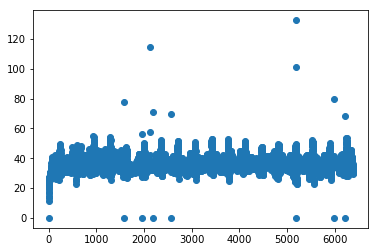

In [5]:
plt.scatter(RaceData.index, RaceData['Speed'])

In [6]:
RaceData = RaceData.drop(RaceData.index[RaceData['Speed'] > 55])
RaceData = RaceData.drop(RaceData.index[RaceData['Speed'] <= 0])
RaceData.shape

(6359, 10)

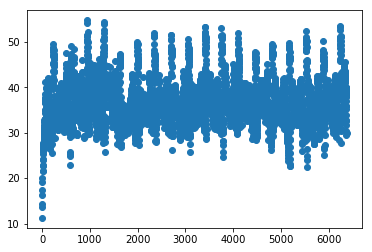

In [7]:
plt.scatter(RaceData.index, RaceData['Speed'])

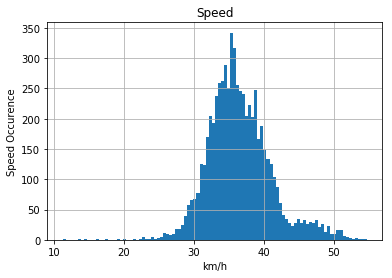

In [8]:
RaceData['Speed'].hist(normed = 0, histtype = 'stepfilled', bins = 100) # Plot Speed on histogram
plt.title('Speed')
plt.xlabel('km/h')
plt.ylabel('Speed Occurence')

count    6359.000000
mean      157.194213
std        17.200971
min       108.000000
25%       148.000000
50%       154.000000
75%       160.000000
max       236.000000
Name: HeartRate, dtype: float64


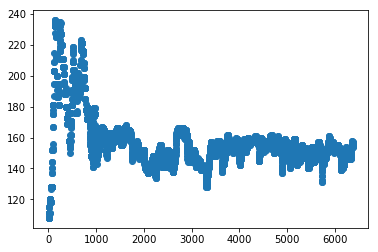

In [12]:
print(RaceData['HeartRate'].describe())
plt.scatter(RaceData.index, RaceData['HeartRate'])

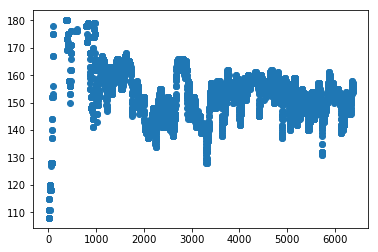

In [16]:
RaceData = RaceData.drop(RaceData.index[RaceData['HeartRate'] > 180])
plt.scatter(RaceData.index, RaceData['HeartRate'])

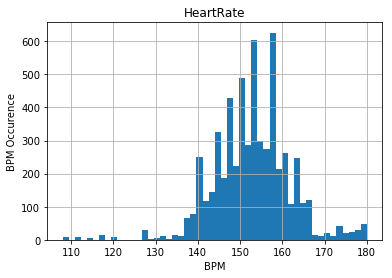

In [18]:
RaceData['HeartRate'] = RaceData['HeartRate'].astype(int) # Change to integer to be able to plot
RaceData['HeartRate'].hist(normed = 0, histtype = 'stepfilled', bins = 50) # Plot Heart Rate on Histogram
plt.title('HeartRate')
plt.xlabel('BPM')
plt.ylabel('BPM Occurence')

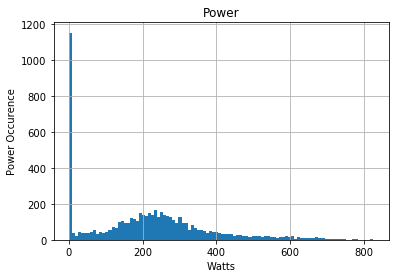

In [19]:
RaceData['Power'] = RaceData['Power'].astype(int)
RaceData['Power'].hist(normed = 0, histtype = 'stepfilled', bins = 100) # Plot Power on Histogram
plt.title('Power')
plt.xlabel('Watts')
plt.ylabel('Power Occurence')

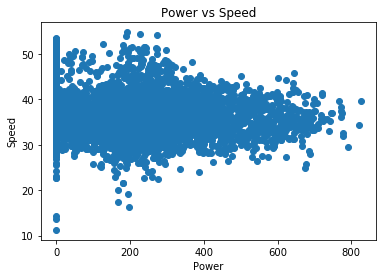

In [20]:
plt.scatter(RaceData['Power'], RaceData['Speed']) # Plot power vs Speed to compare
plt.title('Power vs Speed')
plt.xlabel('Power')
plt.ylabel('Speed')

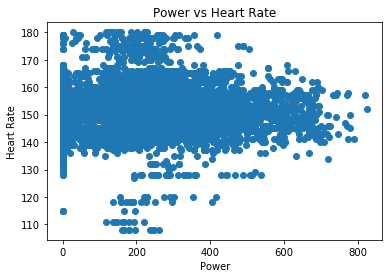

In [21]:
plt.scatter(RaceData['Power'], RaceData['HeartRate']) # Plot power vs Heart Rate
plt.title('Power vs Heart Rate')
plt.xlabel('Power')
plt.ylabel('Heart Rate')

Decided to remove the zeros from power and see if any of the data changed. The power histogram was much easier to look at and shows a bery slight skew to the right.

Both of the Scatterplots remained fairly unchanged however.

In [22]:
RaceData2 = RaceData.drop(RaceData.index[RaceData['Power'] == 0]) # Drop the large amount of '0' out of power

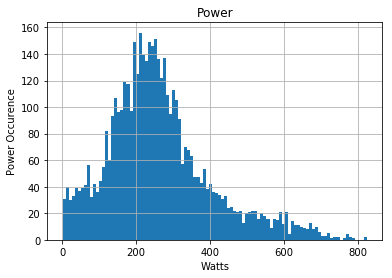

In [23]:
RaceData2['Power'].hist(normed = 0, histtype = 'stepfilled', bins = 100) # Plot power without 0
plt.title('Power')
plt.xlabel('Watts')
plt.ylabel('Power Occurence')

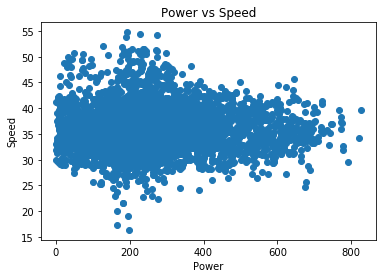

In [24]:
plt.scatter(RaceData2['Power'], RaceData2['Speed']) # Plot sccaterplot without 0 for power vs speed
plt.title('Power vs Speed')
plt.xlabel('Power')
plt.ylabel('Speed')

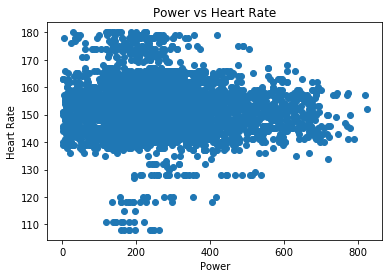

In [25]:
plt.scatter(RaceData2['Power'], RaceData2['HeartRate']) # Plot sccaterplot without 0 for power vs Heart Rate
plt.title('Power vs Heart Rate')
plt.xlabel('Power')
plt.ylabel('Heart Rate')

To find the amount of laps I rounded the points as the gps as you can always pass over slighty different spots than before, so I rounded it up to 5 decimal places.

I made the assumption that the first point in the data is the start point for the race and iterated through the data finding occurences of both those points and came up with 9 laps in total.

In [26]:
RaceData['Longitude'] = RaceData['Longitude'].astype(float) # Make Longitude and Latitude float so I can round them
RaceData['Latitude'] = RaceData['Latitude'].astype(float)
RaceData['Longitude'].round(5) # Round them to 5 decimal places
RaceData['Latitude'].round(5)
laps = -1
for data in RaceData: # itererate through the two points and count how many occurences
    if (RaceData['Longitude'] == 150.87103, RaceData['Latitude'] == -33.81617):
        laps = laps + 1
print("The amount of laps that the rider completes is:", laps)            

The amount of laps that the rider completes is: 9


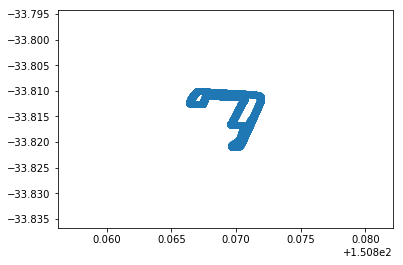

In [27]:
plt.scatter(RaceData['Longitude'].round(5), RaceData['Latitude'].round(5))